In [1]:
import math
import torch
import hess
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
import numpy as np
import sklearn.datasets as datasets
import hess.utils as utils

In [2]:
torch.random.manual_seed(88)

In [3]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [4]:
n_pts = 500
X, Y = twospirals(n_pts, noise=1.)

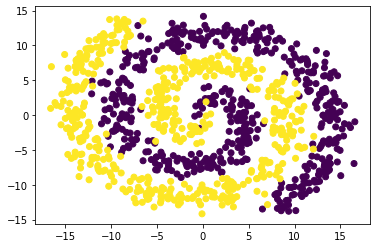

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=Y)

In [6]:
train_x = torch.FloatTensor(X)

In [7]:
train_y = torch.tensor(Y).unsqueeze(-1).float()

In [8]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    train_x, train_y = train_x.cuda(), train_y.cuda()

In [9]:
in_dim = 2
out_dim = 1
model = hess.nets.SimpleNet(in_dim, out_dim, n_hidden=5, hidden_size=20,
                     activation=torch.nn.ELU(), bias=True)

In [10]:
buffer = 0.3
h = 0.1
x_min, x_max = train_x[:, 0].min() - buffer, train_x[:, 0].max() + buffer
y_min, y_max = train_x[:, 1].min() - buffer, train_x[:, 1].max() + buffer

xx,yy=np.meshgrid(np.arange(x_min.cpu(), x_max.cpu(), h), 
                  np.arange(y_min.cpu(), y_max.cpu(), h))
in_grid = torch.FloatTensor([xx.ravel(), yy.ravel()]).t()

In [11]:
print(sum(p.numel() for p in model.parameters()))

2181


In [12]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [13]:
if use_cuda:
    model = model.cuda()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model_loss = torch.nn.BCEWithLogitsLoss()
prior_scale = 100.
prior = torch.distributions.Normal(loc=0., scale=prior_scale)

In [15]:
def loss_func(model, model_loss, train_x, train_y, prior=None):
    N = train_x.shape[0]
    loss = N*model_loss(model(train_x), train_y)
    if prior is not None:
        for p in model.parameters():
            loss -= prior.log_prob(p).sum()
            
    return loss

In [16]:
lambda_loss = lambda mdl : loss_func(mdl, model_loss, train_x, train_y, prior)

In [23]:
for step in range(1000):
    optimizer.zero_grad()
    outputs = model(train_x)

    loss = lambda_loss(model)
    
    if step % 10 == 0:
        print("train loss = ", loss)
    loss.backward()
    optimizer.step()
    
#     ## compute test loss ##
#     outputs = model(test_x)
#     testL = loss_func(outputs,test_y).item()
#     test_losses.append(testL)
#     print("test loss = ", testL)

train loss =  tensor(12488.0176, grad_fn=<SubBackward0>)
train loss =  tensor(12381.7549, grad_fn=<SubBackward0>)
train loss =  tensor(12243.4160, grad_fn=<SubBackward0>)
train loss =  tensor(12148.2031, grad_fn=<SubBackward0>)
train loss =  tensor(12166.5801, grad_fn=<SubBackward0>)
train loss =  tensor(12148.4541, grad_fn=<SubBackward0>)
train loss =  tensor(12115.4688, grad_fn=<SubBackward0>)
train loss =  tensor(12105.7764, grad_fn=<SubBackward0>)
train loss =  tensor(12100.3965, grad_fn=<SubBackward0>)
train loss =  tensor(12095.0098, grad_fn=<SubBackward0>)
train loss =  tensor(12091.0508, grad_fn=<SubBackward0>)
train loss =  tensor(12087.0898, grad_fn=<SubBackward0>)
train loss =  tensor(12084.6592, grad_fn=<SubBackward0>)
train loss =  tensor(12082.9961, grad_fn=<SubBackward0>)
train loss =  tensor(12081.6211, grad_fn=<SubBackward0>)
train loss =  tensor(12080.4160, grad_fn=<SubBackward0>)
train loss =  tensor(12079.3545, grad_fn=<SubBackward0>)
train loss =  tensor(12078.3613

In [24]:
outputs.shape

torch.Size([1000, 1])

In [25]:
print(model(train_x).shape)

torch.Size([1000, 1])


In [26]:
saved_pars = model.state_dict()

In [27]:
pred = torch.sigmoid(model(in_grid)).reshape(xx.shape).detach()

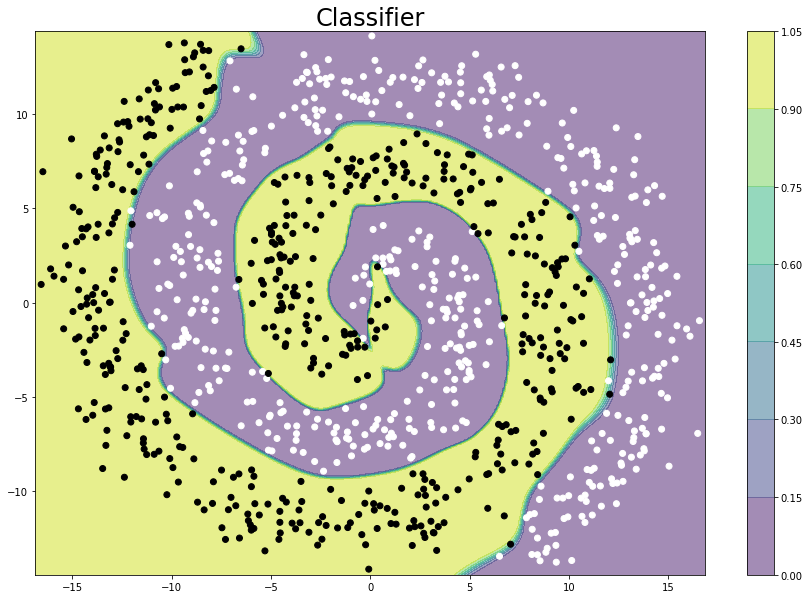

In [28]:
plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, pred, alpha=0.5)
# plt.title("Temp Scaled", fontsize=24)
plt.title("Classifier", fontsize=24)
plt.colorbar()
plt.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary)
# plt.savefig("./two-spiral-classifier.pdf", bbox_inches="tight")

## Compute Hessian

In [29]:
import hess.utils as utils

In [30]:
par_list = model.parameters()
n_par = sum(torch.numel(p) for p in par_list)

In [31]:
hessian = torch.zeros(n_par, n_par)
for pp in range(n_par):
    base_vec = torch.zeros(n_par).unsqueeze(0)
    base_vec[0, pp] = 1.
    
    base_vec = utils.unflatten_like(base_vec, model.parameters())
    utils.eval_hess_vec_prod(base_vec, model,
                            criterion=lambda_loss,
                            inputs=train_x, targets=train_y)
    if pp == 0:
        output = utils.gradtensor_to_tensor(model, include_bn=True)
        hessian = torch.zeros(output.nelement(), output.nelement())
        hessian[:, pp] = output
    
#     print(pp)
    hessian[:, pp] = utils.gradtensor_to_tensor(model, include_bn=True).cpu()

In [32]:
e_val, e_vec = np.linalg.eig(hessian.cpu())
idx = np.abs(e_val).argsort()[::-1]   
e_val = torch.FloatTensor(e_val[idx].real)
e_vec = torch.FloatTensor(e_vec[:,idx].real)

## Get Loss Surfaces

In [33]:
range_ = 1.
scale = 1.
n_pts = 75

In [34]:
basis = e_vec
full_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [35]:
nvec = 3
basis = e_vec[:, :nvec]
high_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [36]:
nvec = 1000
basis = e_vec[:, -nvec:]
low_loss_surface = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=n_pts, scale=scale,
                                             use_cuda=False)

In [37]:
ymin = torch.min(full_loss_surface).log()
ymax = torch.max(full_loss_surface).log()

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((bottom(np.linspace(1, 0, 128)),
                       top(np.linspace(1, 0, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

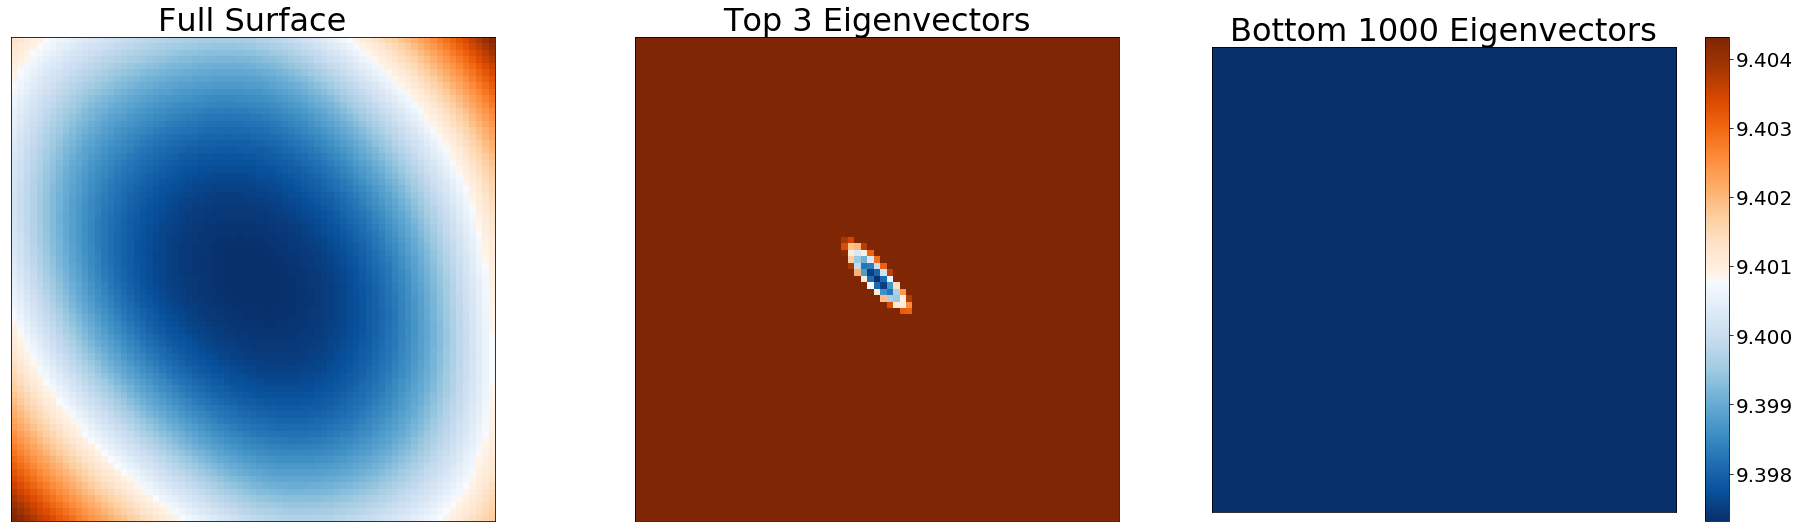

In [38]:
title_fs = 32

fig, ax = plt.subplots(1, 3, figsize=(26, 7.5))
im = ax[0].imshow(full_loss_surface.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# ax[0].autoscale(False)
# cbar=fig.colorbar(im, ax=ax[0])
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Full Surface",
               fontsize=title_fs)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(high_loss_surface.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[1])
# cbar.ax.tick_params(labelsize=20)
# ax[1].autoscale(False)
ax[1].set_title("Top 3 Eigenvectors",
               fontsize=title_fs)
ax[1].set_xticks([])
ax[1].set_yticks([])

im = ax[2].imshow(low_loss_surface.log().detach(), cmap=newcmp, vmin=ymin, vmax=ymax)
cbar=fig.colorbar(im, ax=ax[2])
cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[2].set_title("Bottom 1000 Eigenvectors",
               fontsize=title_fs);
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.tight_layout()

plt.show()


In [39]:
model.load_state_dict(saved_pars)

<All keys matched successfully>

In [60]:
scale = 1.
range_ = 10.
basis = e_vec
ls1 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=50, scale=scale,
                                             use_cuda=False)

In [61]:
nvec = 1000
basis = e_vec[:, -nvec:]
ls2 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=50, scale=scale,
                                             use_cuda=False)

basis = e_vec[:, -3:]
ls3 = loss_surfaces.get_loss_surface(basis, model,
                                             train_x, train_y,
                                             loss=lambda_loss,
                                             rng=range_, n_pts=50, scale=scale,
                                             use_cuda=False)

In [62]:
ymin = torch.min(ls1).log()
ymax = torch.max(ls1).log()

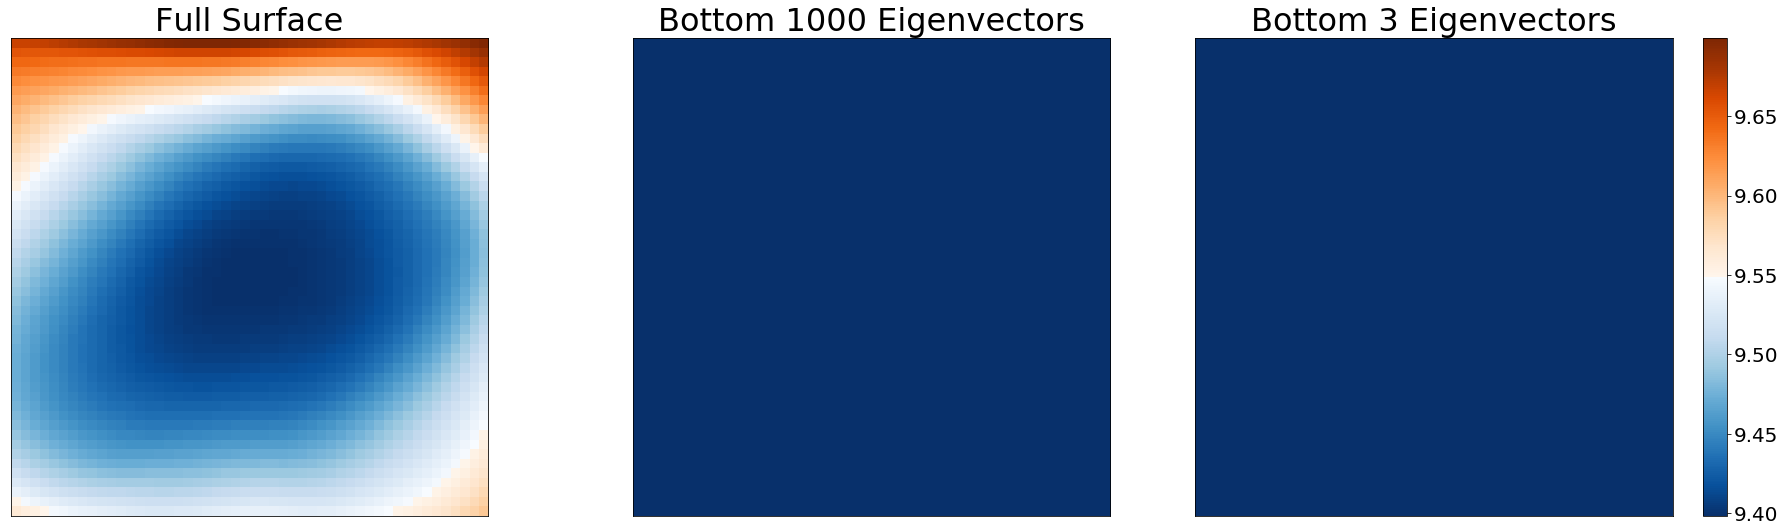

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(26, 7.5))
im = ax[0].imshow(ls1.log().detach(), cmap=newcmp)
# ax[0].autoscale(False)
# cbar=fig.colorbar(im, ax=ax[0])
cbar.ax.tick_params(labelsize=20)
cbar.ax.yaxis.offsetText.set(size=20)
ax[0].set_title("Full Surface",
               fontsize=title_fs)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(ls2.log().detach(), cmap=newcmp,
                 vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[1])
cbar.ax.tick_params(labelsize=20)
# ax[1].autoscale(False)
ax[1].set_title("Bottom %i Eigenvectors" % nvec,
               fontsize=title_fs)
ax[1].set_xticks([])
ax[1].set_yticks([])

im = ax[2].imshow(ls3.log().detach(), cmap=newcmp, vmin=ymin, vmax=ymax)
# cbar=fig.colorbar(im, ax=ax[2])
# cbar.ax.tick_params(labelsize=20)
# cbar.ax.yaxis.offsetText.set(size=20)
ax[2].set_title("Bottom 3 Eigenvectors",
               fontsize=title_fs);
ax[2].set_xticks([])
ax[2].set_yticks([])
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()


plt.show()

In [40]:
pars = utils.flatten([p for p in model.parameters()]) 

In [41]:
par_vector_len = pars.norm()

In [42]:
par_vector_len

tensor(13.8901, grad_fn=<NormBackward0>)

### Generate Parameter Perturbations in Low-Curvature Directions

In [43]:
model.load_state_dict(saved_pars)
orig_preds = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)
orig_pt_pred = torch.sigmoid(model(train_x))

In [49]:
n_vec = 1000
scale = par_vector_len
basis = e_vec[:, -n_vec:]

model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]

low_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)
low_pt_pred = torch.sigmoid(model(train_x))

In [62]:
n_vec = 3
scale = 0.12
basis = e_vec[:, :n_vec]


model.load_state_dict(saved_pars)
wghts = torch.randn(n_vec).cpu()
perturb = basis.matmul(wghts.unsqueeze(-1)).t()
perturb = perturb.div(perturb.norm()).mul(scale)

perturb = utils.unflatten_like(perturb, model.parameters())
for i, par in enumerate(model.parameters()):
    par.data = par.data + perturb[i]

high_pred = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [63]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

In [64]:
import seaborn as sns
import pandas as pd

dat = pd.DataFrame({'x1': train_x[:, 0], 'x2': train_x[:, 1], "y":train_y[:, 0]})

[Text(0, 0.5, ''), Text(0.5, 0, '')]

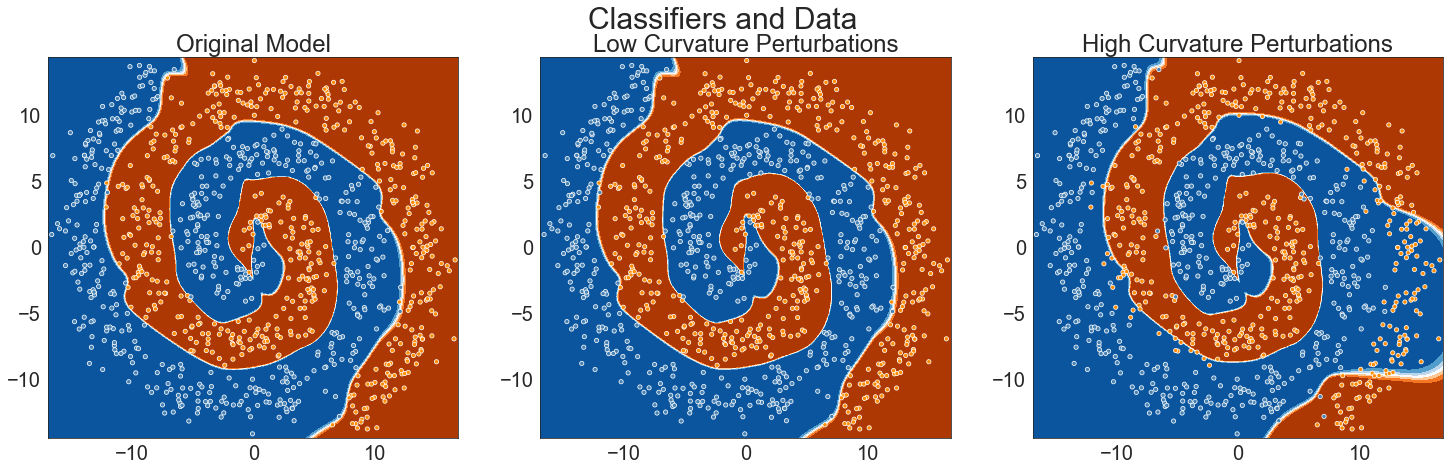

In [65]:
sup_fs = 30
title_fs = 24
ax_fs = 20
colors = newcmp


sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7))

fig.suptitle('Classifiers and Data', fontsize=sup_fs)


ax1.contourf(xx, yy, orig_preds.detach(), cmap=colors)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax1,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax1.set_title("Original Model", fontsize=title_fs)
ax1.tick_params(axis="both", labelsize=ax_fs)
ax1.set(xlabel='', ylabel='')

ax2.contourf(xx, yy, low_pred.detach(), cmap=colors)
# ax2.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#            s=3)
ax2.set_title("Low Curvature Perturbations", fontsize=title_fs)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax2,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax2.tick_params(axis="both", labelsize=ax_fs)
ax2.set(xlabel='', ylabel='')

ax3.contourf(xx, yy, high_pred.detach(), cmap=colors)
# ax3.scatter(train_x[:, 0].cpu(), train_x[:, 1].cpu(), c=train_y[:, 0].cpu(), cmap=plt.cm.binary,
#         s=3)
sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=ax3,
               palette=['darkorange', 'steelblue'], size=1, legend=False)
ax3.set_title("High Curvature Perturbations", fontsize=title_fs)
ax3.tick_params(axis="both", labelsize=ax_fs)
ax3.set(xlabel='', ylabel='')


### Do the Original and Low Curvature Models predict the same?

In [66]:
orig_pt_pred[orig_pt_pred < 0.5] = 0
orig_pt_pred[orig_pt_pred >= 0.5] = 1

low_pt_pred[low_pt_pred < 0.5] = 0
low_pt_pred[low_pt_pred >= 0.5] = 1

In [67]:
torch.sum((orig_pt_pred - low_pt_pred).abs())

tensor(0., grad_fn=<SumBackward0>)

## Quantify Sensitivity to Perturbations

In [75]:
n_bases = 5
n_scale = 5
max_scale = 1.
scales = torch.linspace(0, max_scale, n_scale)
loss_outs = torch.zeros(n_bases, n_scale)
loss_func = torch.nn.BCEWithLogitsLoss()
n_restarts = 10

for base in range(n_bases):
    for scale_ind, scale in enumerate(scales):
        basis = e_vec[:, :(base+1)]
        temp_losses = torch.zeros(n_restarts)
        for rst in range(n_restarts):

            model.load_state_dict(saved_pars)
            wghts = torch.randn(base+1).cpu()
            perturb = basis.matmul(wghts.unsqueeze(-1)).t()
            perturb = perturb.div(perturb.norm()).mul(scale)

            perturb = utils.unflatten_like(perturb, model.parameters())
            for i, par in enumerate(model.parameters()):
                par.data = par.data + perturb[i]

            outputs = model(train_x)
            temp_losses[rst] = loss_func(outputs, train_y).item()
            
        loss_outs[base,  scale_ind] = temp_losses.mean()

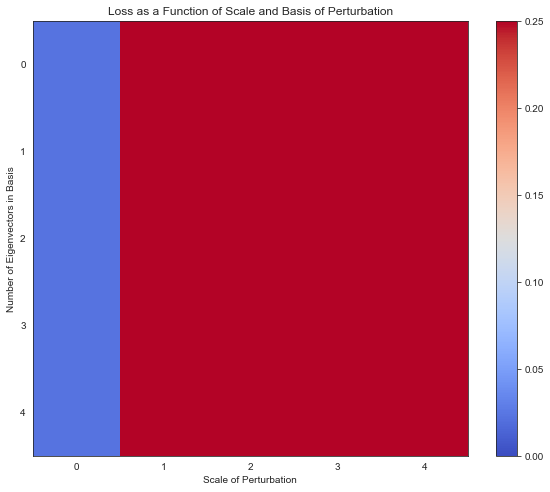

In [76]:
plt.figure(figsize=(10, 8))
plt.imshow(loss_outs.detach(), cmap="coolwarm", vmin=0., vmax=0.25)
plt.colorbar()
plt.ylabel("Number of Eigenvectors in Basis")
plt.xlabel("Scale of Perturbation")
# plt.yticks(np.arange(0, n_bases, 5), np.arange(0, n_bases, 5), va='center')
# plt.yticks(np.arange(n_bases), 1+np.arange(n_bases))
loc, lab = plt.yticks()
plt.title("Loss as a Function of Scale and Basis of Perturbation")
plt.show()

## And Plot some Sample Classifiers

In [97]:
n_vec = 1
n_scale = 10
max_scale = 0.2
scales = torch.linspace(0, max_scale, n_scale)
basis = e_vec[:, :n_vec]
high_preds = torch.zeros(n_scale, xx.shape[0], xx.shape[1])

for scl_ind, scl in enumerate(scales):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scl)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]

    high_preds[scl_ind, :, :] = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [98]:
n_vec = 1000
basis = e_vec[:, -n_vec:]
low_preds = torch.zeros(n_scale, xx.shape[0], xx.shape[1])

n_scale = 10
max_scale = par_vector_len.item()
low_scales = torch.linspace(0, max_scale, n_scale)
for scl_ind, scl in enumerate(low_scales):
    model.load_state_dict(saved_pars)
    wghts = torch.randn(n_vec).cpu()
    perturb = basis.matmul(wghts.unsqueeze(-1)).t()
    perturb = perturb.div(perturb.norm()).mul(scl)

    perturb = utils.unflatten_like(perturb, model.parameters())
    for i, par in enumerate(model.parameters()):
        par.data = par.data + perturb[i]

    low_preds[scl_ind, :, :] = torch.sigmoid(model(in_grid).squeeze().cpu()).reshape(xx.shape)

In [99]:
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

subtitle_fs = 26
title_fs = 40

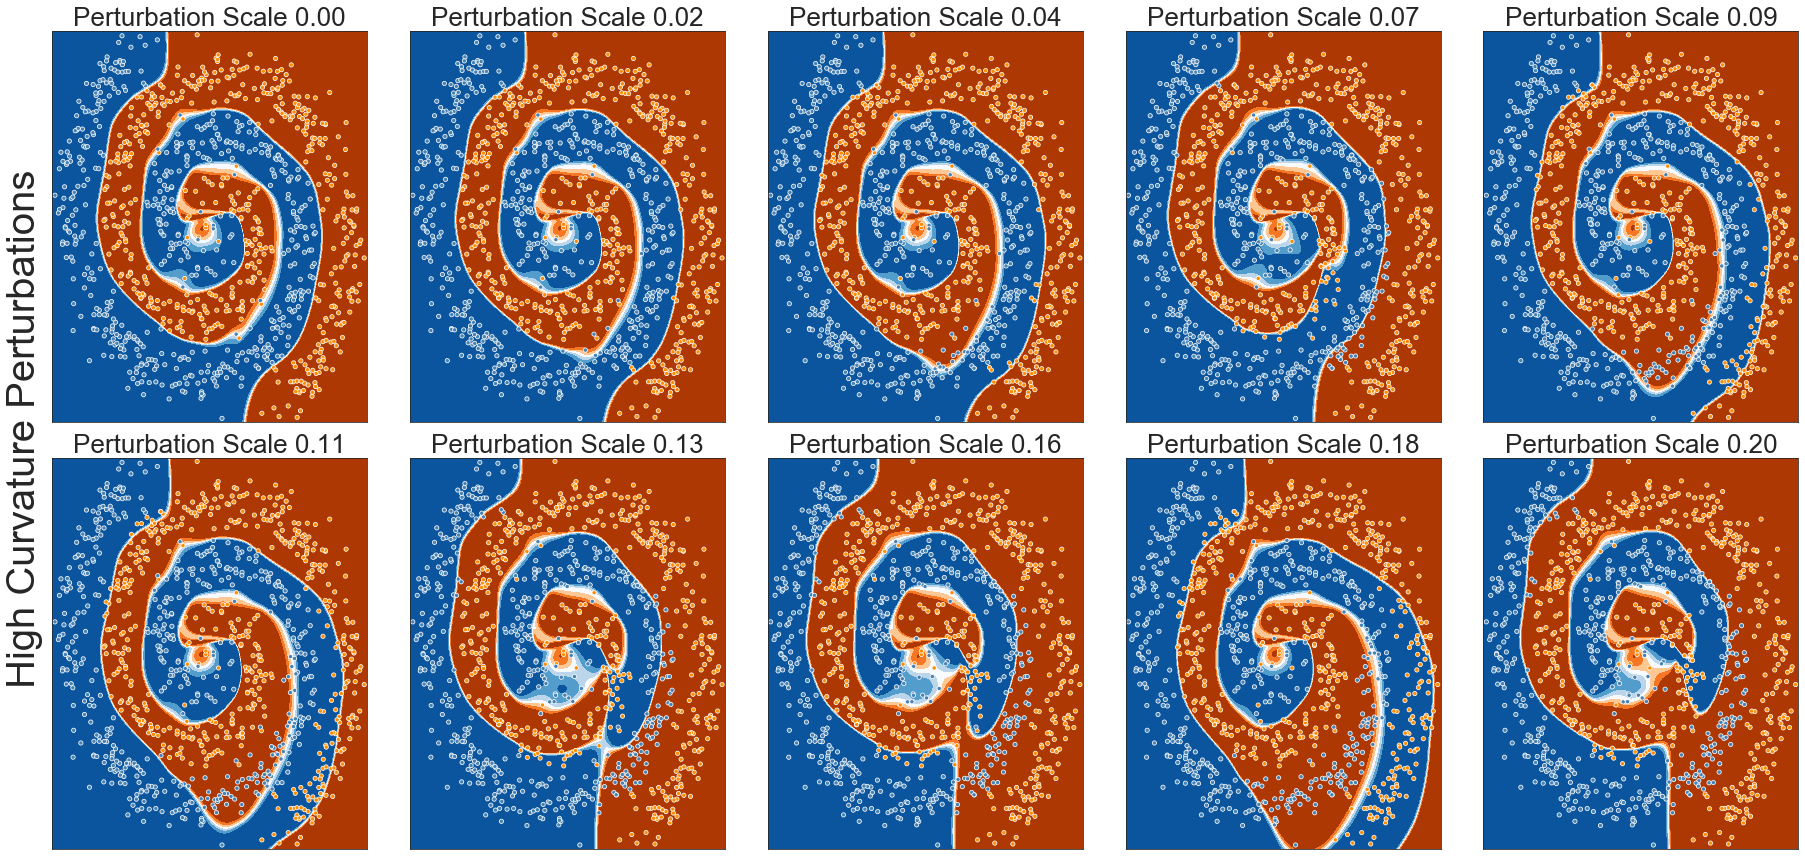

In [100]:
sns.set_style("white")
f, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=True)
for ii in range(2):
    for scl_ind in range(5):
        axes[ii, scl_ind].contourf(xx, yy, high_preds[ii*5 + scl_ind, :, :].detach(),
                                  cmap=newcmp)
        sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=axes[ii, scl_ind],
                       palette=['darkorange', 'steelblue'], size=1, legend=False)
        axes[ii, scl_ind].set_ylabel("")
        axes[ii, scl_ind].set_xlabel("")
        axes[ii, scl_ind].set_title("Perturbation Scale %.2f"  % scales[ii*5 + scl_ind].item(),
                                   fontsize=subtitle_fs)

plt.setp(axes, yticks=[], xticks=[])
f.text(-0.01, 0.5, 'High Curvature Perturbations', va='center', rotation='vertical',
      fontsize=title_fs)
plt.tight_layout()

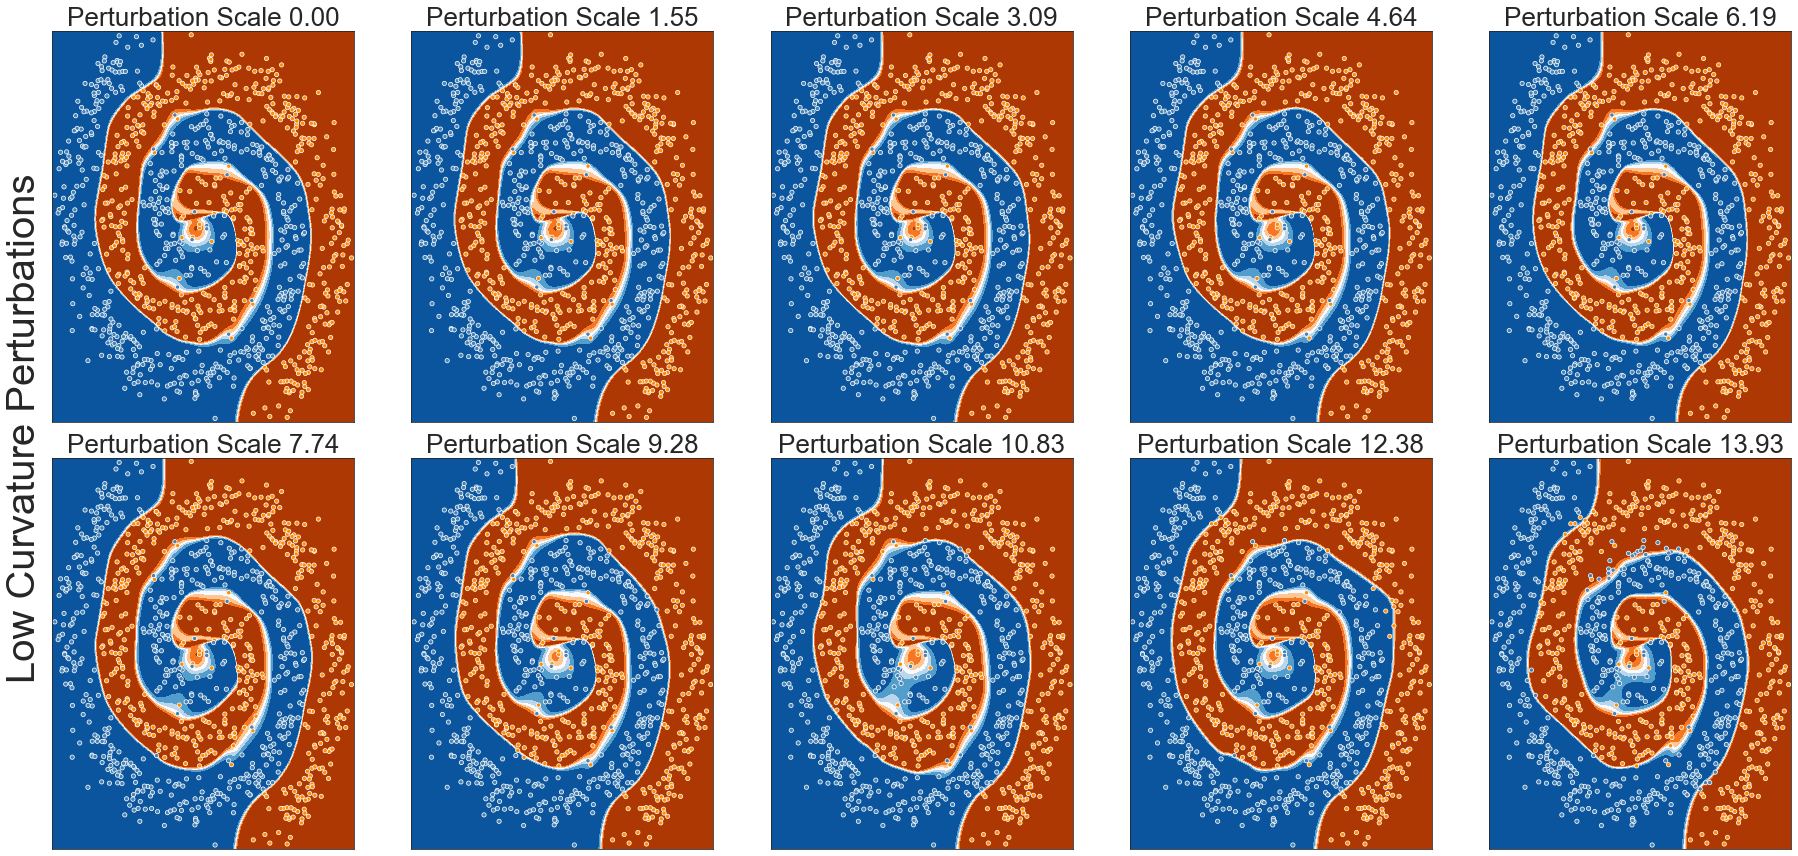

In [101]:
sns.set_style("white")
f, axes = plt.subplots(2, 5, figsize=(25, 12), sharex=True)
for ii in range(2):
    for scl_ind in range(5):
        axes[ii, scl_ind].contourf(xx, yy, low_preds[ii*5 + scl_ind, :, :].detach(),
                                  cmap=newcmp)
        sns.scatterplot(x='x1', y='x2', hue='y', data=dat, ax=axes[ii, scl_ind],
                       palette=['darkorange', 'steelblue'], size=1, legend=False)
        axes[ii, scl_ind].set_ylabel("")
        axes[ii, scl_ind].set_xlabel("")
        axes[ii, scl_ind].set_title("Perturbation Scale %.2f"  % low_scales[ii*5 + scl_ind].item(),
                                   fontsize=subtitle_fs)

plt.setp(axes, yticks=[], xticks=[])
f.text(-0.01, 0.5, 'Low Curvature Perturbations', va='center', rotation='vertical',
      fontsize=title_fs)
plt.tight_layout()